# 🌍 Segmentación Socioeconómica de Países (Clustering)
**Proyecto de Aprendizaje No Supervisado**

* **Autor:** Luis Mauricio Aguirre Stornaiuolo
* **Contexto:** Simulación para el Banco Mundial / ONG Internacional

---

### 📋 Contexto del Negocio
Una organización internacional busca optimizar la asignación de fondos de ayuda humanitaria. El objetivo es categorizar 167 países basándose en factores socioeconómicos y de salud, sin utilizar etiquetas predefinidas (países ricos vs. pobres), para identificar objetivamente aquellos con necesidades más críticas.

### 🎯 Objetivos
1.  **Analizar:** Explorar patrones en variables macroeconómicas (PIB, Inflación, Exportaciones) y de salud (Mortalidad infantil, Esperanza de vida).
2.  **Agrupar:** Utilizar el algoritmo **K-Means** para segmentar los países en clusters homogéneos.
3.  **Perfilar:** Interpretar los grupos resultantes para generar recomendaciones estratégicas de inversión y ayuda.

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ruta = "https://raw.githubusercontent.com/MrPinkiePie/unsupervised_countries_analysis/refs/heads/main/Country-data.csv"

In [3]:
data = pd.read_csv(ruta)

In [4]:
data.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
data.shape

(167, 10)

In [6]:
data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [7]:
cor = data.select_dtypes("number").corr()

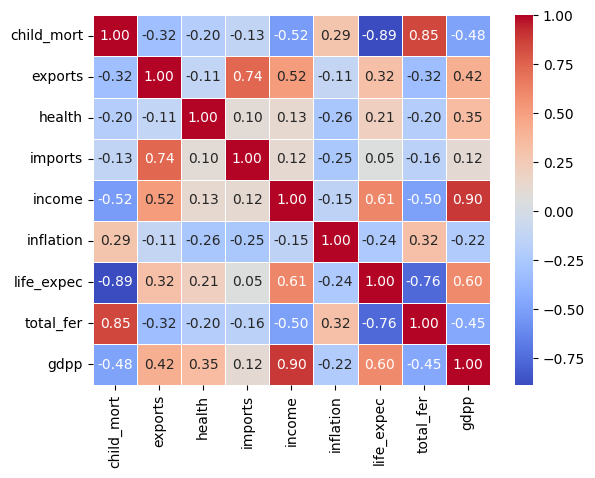

In [8]:
sns.heatmap(cor,annot=True,fmt=".2f",cmap='coolwarm',linewidths=.5)
plt.show()

In [9]:
numeric_cols = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp']

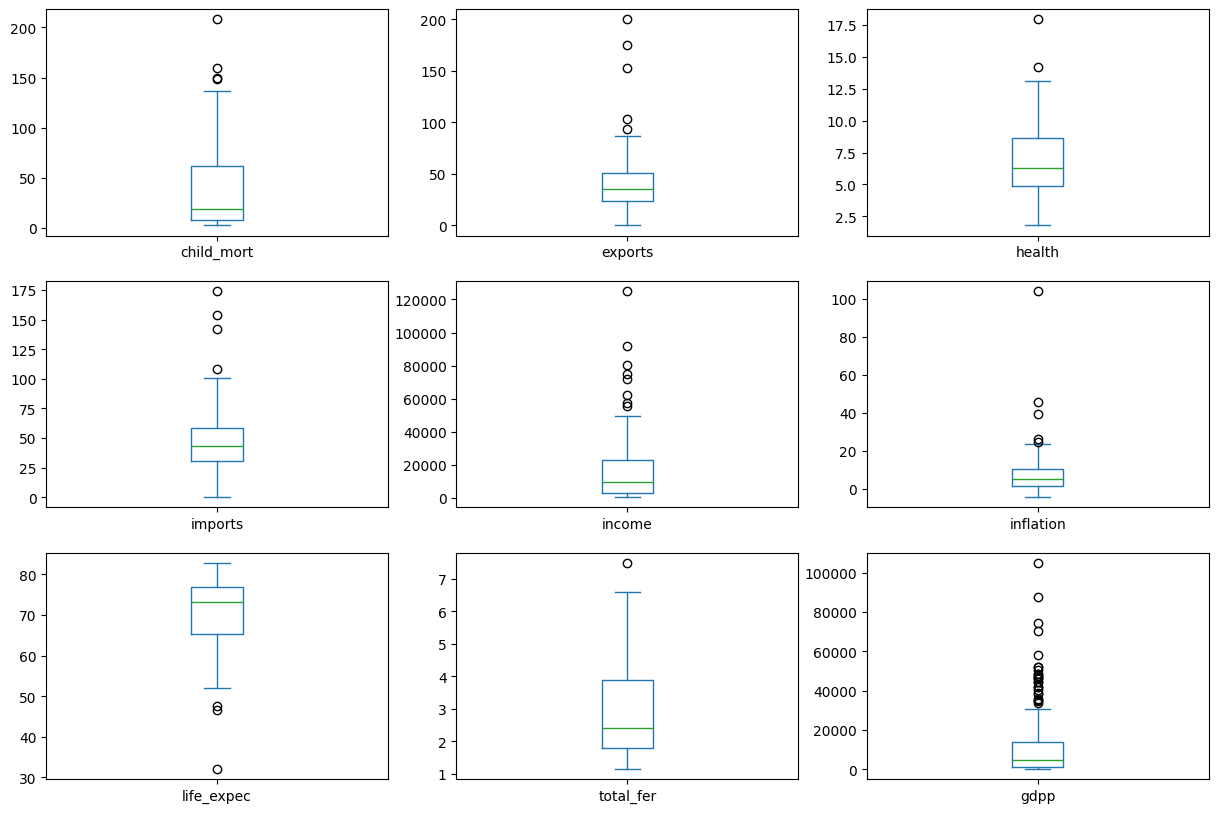

In [10]:
data[numeric_cols].plot(kind="box",subplots=True,layout=(3,3),figsize=(15,10))
plt.show()

In [11]:
for col in numeric_cols:
  q1 = data[col].quantile(0.25)
  q3 = data[col].quantile(0.75)
  iqr = q3 - q1
  l_inf = q1 - 1.5*iqr
  l_sup = q3 + 1.5*iqr
  #imprimimos el porcentaje y cantidad de outliers con el método query
  outliers_df = data.query(f"{col} < @l_inf or {col} > @l_sup")
  n_outliers = len(outliers_df)
  print(f"La columna {col} tiene un total de {n_outliers}, lo que representa un {(n_outliers/(len(data))):.2%}")

La columna child_mort tiene un total de 4, lo que representa un 2.40%
La columna exports tiene un total de 5, lo que representa un 2.99%
La columna health tiene un total de 2, lo que representa un 1.20%
La columna imports tiene un total de 4, lo que representa un 2.40%
La columna income tiene un total de 8, lo que representa un 4.79%
La columna inflation tiene un total de 5, lo que representa un 2.99%
La columna life_expec tiene un total de 3, lo que representa un 1.80%
La columna total_fer tiene un total de 1, lo que representa un 0.60%
La columna gdpp tiene un total de 25, lo que representa un 14.97%


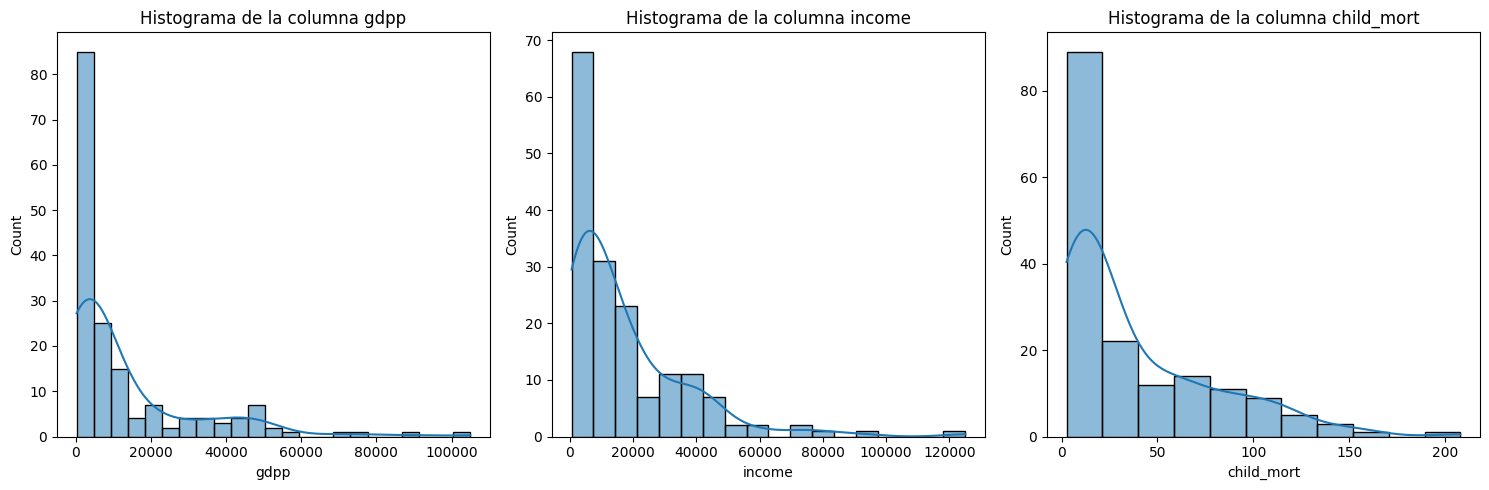

In [12]:
cols_to_check = ["gdpp","income","child_mort"]
plt.figure(figsize=(15,5))
for idx,col in enumerate(cols_to_check):
  plt.subplot(1,3, idx+1)
  sns.histplot(data[col],kde = True)
  plt.title(f"Histograma de la columna {col}")
  plt.xlabel(col)

plt.tight_layout()
plt.show()


### 🛠️ Preprocesamiento de Datos: Manejo de Sesgo Económico

**Desafío Detectado:**
Variables como el `gdpp` (PIB per cápita) y `income` (Ingreso) presentan una distribución de "Cola Larga" (Distribución de Pareto), típica en economía: muchos países con ingresos bajos/medios y muy pocos con ingresos extremadamente altos.

**Estrategia:**
No eliminaremos a los países ricos (outliers) ya que son información valiosa. En su lugar, aplicaremos una **Transformación Logarítmica** para comprimir la escala y reducir el sesgo (skewness), permitiendo que el modelo K-Means procese mejor las distancias sin que los valores extremos dominen el cálculo.

In [13]:
data["gdpp_log"] = np.log(data["gdpp"])
data["income_log"] = np.log(data["income"])
data["child_mort_log"] = np.log(data["child_mort"])

## Análisis preliminar

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [15]:
scaler = StandardScaler()

In [16]:
cols_model = [
    'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer', # Las originales
    'gdpp_log', 'income_log', 'child_mort_log'
]
X = data[cols_model].copy()

In [17]:
X_scaled = scaler.fit_transform(X)

In [18]:
X_scaled_df = pd.DataFrame(X_scaled,columns=X.columns)

### 📉 Reducción de Dimensionalidad (PCA)

Dado que contamos con 9 variables macroeconómicas, es imposible visualizar la agrupación de países en un gráfico simple.

Utilizaremos **Análisis de Componentes Principales (PCA)** para "comprimir" estas 9 dimensiones en solo 2 Componentes Principales (PC1 y PC2), reteniendo la mayor cantidad de información (varianza) posible. Esto nos permitirá visualizar el mapa de países en un plano 2D.

In [19]:
pca = PCA(n_components=2)

In [20]:
pca_data = pca.fit_transform(X_scaled_df)
pca_df = pd.DataFrame(pca_data,columns=["PC1","PC2"])
pca_df["Country"] = data["country"]
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_.sum():.2%}")
print(pca_df.head())

Varianza explicada por cada componente: 70.24%
        PC1       PC2              Country
0  3.465900  0.023917          Afghanistan
1 -0.600756 -0.393569              Albania
2  0.084690 -0.532392              Algeria
3  2.481092  1.079068               Angola
4 -1.449914  0.222055  Antigua and Barbuda


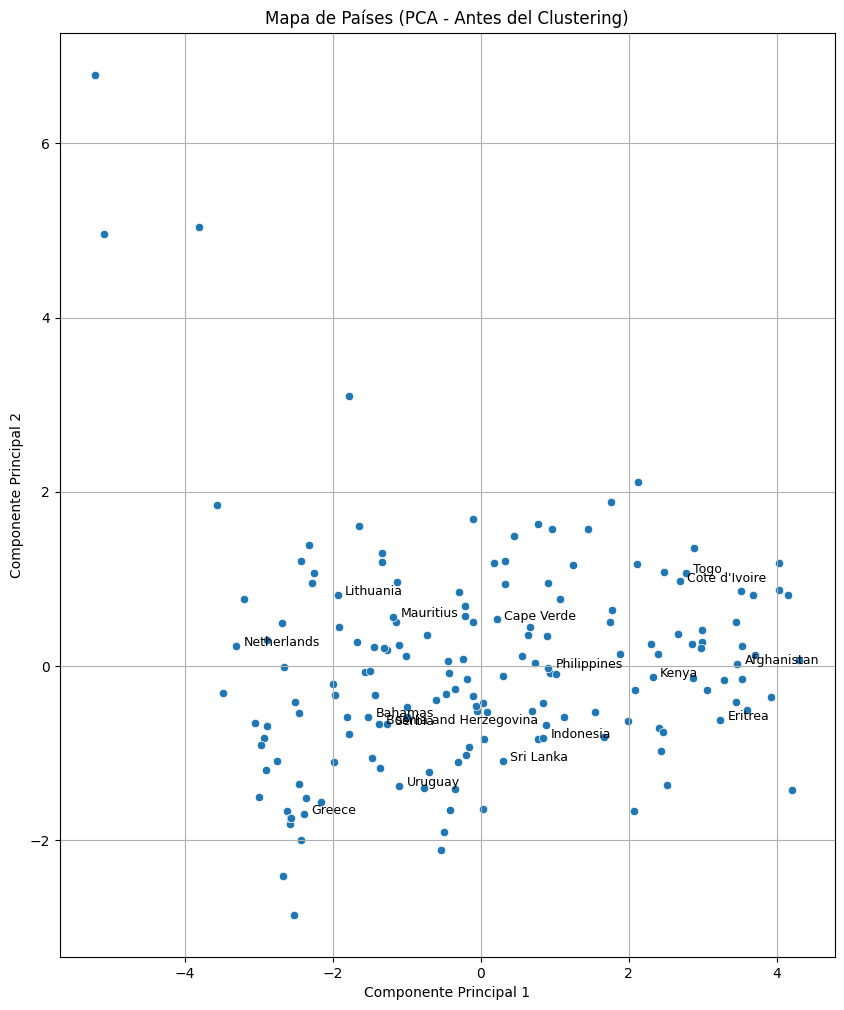

In [21]:
plt.figure(figsize=(10,12))
sns.scatterplot(data = pca_df,x="PC1",y="PC2")
for i in range(0,len(pca_df),10):
  plt.text(pca_df.PC1[i]+0.1, pca_df.PC2[i], pca_df.Country[i], fontsize=9)
plt.title('Mapa de Países (PCA - Antes del Clustering)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

### 🤖 Modelado: Determinación del Número Óptimo de Clusters (k)

Para decidir en cuántos grupos dividir el mundo, utilizaremos dos criterios técnicos:
1.  **Método del Codo (Elbow Method):** Buscamos el punto donde la inercia (error) deja de disminuir drásticamente.
2.  **Silhouette Score:** Evaluamos qué tan bien definidos y separados están los grupos.

*Nota:* Buscamos un equilibrio entre la métrica matemática y la interpretabilidad económica para el negocio.

In [22]:
inertia = []
range_k = range(1,11)
for k in range_k:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(X_scaled_df)
  inertia.append(kmeans.inertia_)

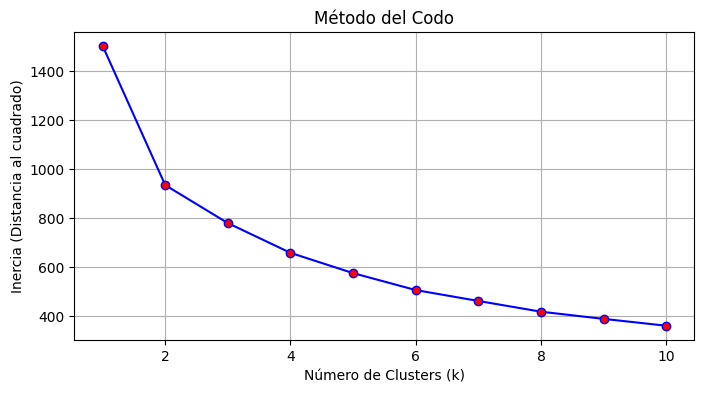

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range_k, inertia, 'bo-', markerfacecolor='red')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Distancia al cuadrado)')
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import silhouette_score

print("Silhouette Score para diferentes k:")
print("-----------------------------------")

for k in range(2, 6): # Probemos de 2 a 5
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    score = silhouette_score(X_scaled_df, kmeans.labels_)
    print(f"Para k = {k}, el Silhouette Score es: {score:.4f}")

Silhouette Score para diferentes k:
-----------------------------------
Para k = 2, el Silhouette Score es: 0.3447
Para k = 3, el Silhouette Score es: 0.2455
Para k = 4, el Silhouette Score es: 0.2679
Para k = 5, el Silhouette Score es: 0.2700


## Modelado

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

In [26]:
kmeans.fit(X_scaled_df)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [27]:
data['Cluster_ID'] = kmeans.labels_

In [28]:
pca_df['Cluster_ID'] = kmeans.labels_

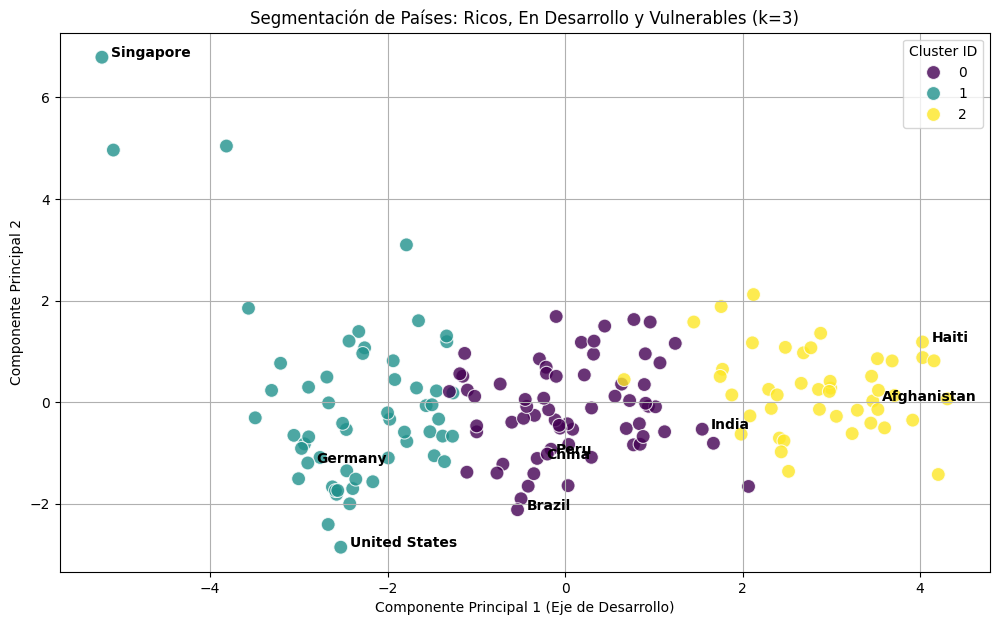

In [29]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_ID', data=pca_df, palette='viridis', s=100, alpha=0.8)
paises_clave = ['United States', 'China', 'India', 'Haiti', 'Peru', 'Germany', 'Afghanistan', 'Singapore',"Brazil"]

for i in range(len(pca_df)):
    if pca_df['Country'][i] in paises_clave:
        plt.text(pca_df.PC1[i]+0.1, pca_df.PC2[i], pca_df.Country[i], fontsize=10, weight='bold')

plt.title('Segmentación de Países: Ricos, En Desarrollo y Vulnerables (k=3)')
plt.xlabel('Componente Principal 1 (Eje de Desarrollo)')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster ID')
plt.grid(True)
plt.show()

### 📊 Profiling y Caracterización de Clusters

Una vez entrenado el modelo con **k=3**, procedemos a interpretar el perfil económico de cada grupo analizando los promedios de sus indicadores clave.

In [30]:
metricas_clave = ['gdpp', 'income', 'child_mort', 'inflation', 'life_expec']

resumen_clusters = data.groupby('Cluster_ID')[metricas_clave].mean().sort_values('gdpp', ascending=False)

resumen_clusters['Conteo_Paises'] = data.groupby('Cluster_ID')['country'].count()

print(resumen_clusters.round(2))

                gdpp    income  child_mort  inflation  life_expec  \
Cluster_ID                                                          
1           31279.46  35636.07        6.62       2.50       78.68   
0            5556.09  11645.30       28.14       9.60       71.08   
2            1036.93   2198.96       92.51      11.69       59.68   

            Conteo_Paises  
Cluster_ID                 
1                      56  
0                      66  
2                      45  


/tmp/ipython-input-1244206692.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='gdpp', data=data, ax=axes[0], palette='viridis')
/tmp/ipython-input-1244206692.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='income', data=data, ax=axes[1], palette='viridis')
/tmp/ipython-input-1244206692.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segmento', y='child_mort', data=data, ax=axes[2], palette='viridis')


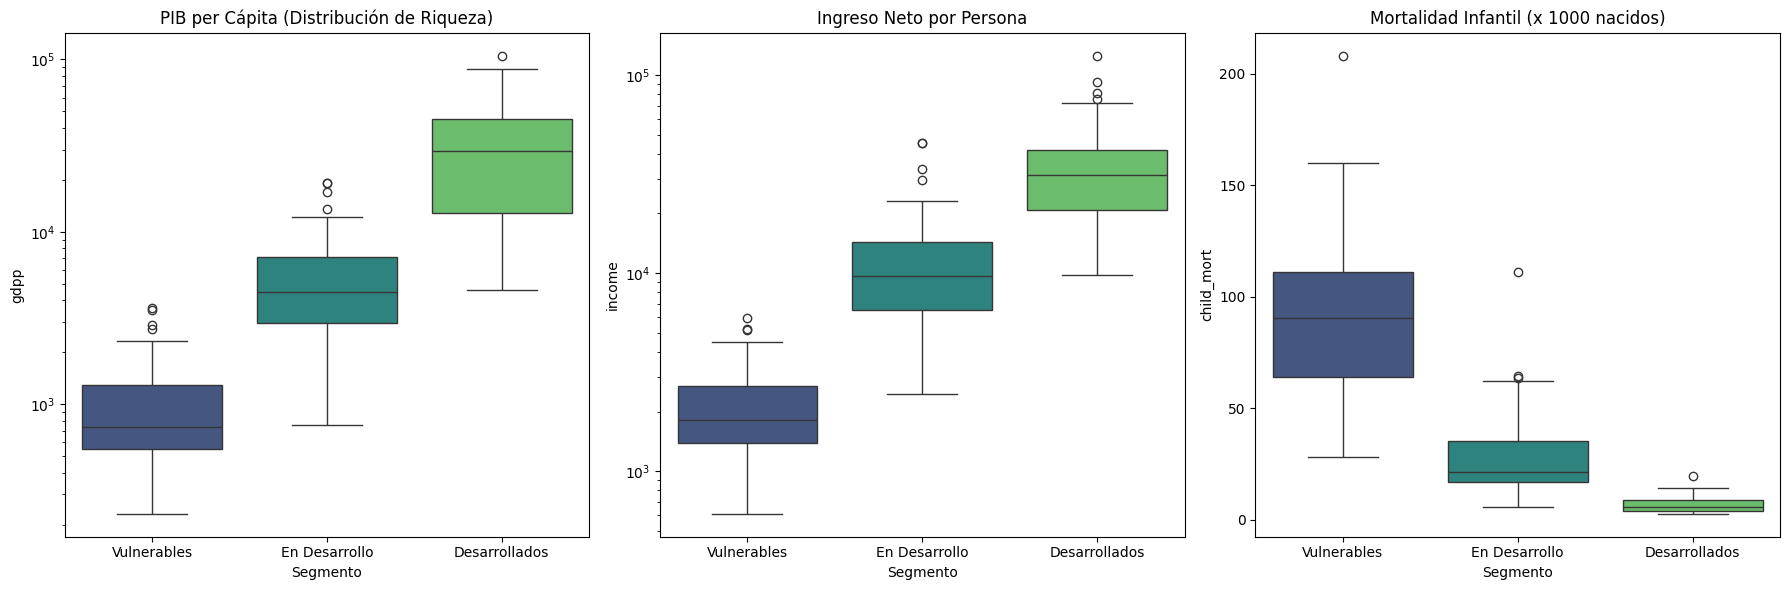

In [31]:
cluster_mapping = {
    1: 'Desarrollados',
    0: 'En Desarrollo',
    2: 'Vulnerables'
}

data['Segmento'] = data['Cluster_ID'].map(cluster_mapping)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='Segmento', y='gdpp', data=data, ax=axes[0], palette='viridis')
axes[0].set_title('PIB per Cápita (Distribución de Riqueza)')
axes[0].set_yscale('log') #para ver mejor las cajas

# Gráfico
sns.boxplot(x='Segmento', y='income', data=data, ax=axes[1], palette='viridis')
axes[1].set_title('Ingreso Neto por Persona')
axes[1].set_yscale('log')

# Gráfico Mortalidad Infantil
sns.boxplot(x='Segmento', y='child_mort', data=data, ax=axes[2], palette='viridis')
axes[2].set_title('Mortalidad Infantil (x 1000 nacidos)')

plt.tight_layout()
plt.show()

# 🚀 Conclusiones y Recomendaciones Estratégicas

Tras el análisis de segmentación utilizando K-Means, hemos identificado 3 perfiles de países claramente diferenciados. La matemática (PCA y Boxplots) confirma que la división obedece a factores estructurales de riqueza y salud.

### 🔍 Hallazgos Principales:

1.  **Cluster "Vulnerables" (Prioridad Alta):**
    * **Característica:** Países con alta mortalidad infantil (Promedio > 90 muertes/1000 nacimientos) y PIB per cápita muy bajo.
    * **Acción Recomendada:** Este grupo requiere **Ayuda Humanitaria Urgente** (vacunación, alimentos, medicina básica). No son candidatos a créditos tradicionales por su bajo retorno inmediato.

2.  **Cluster "En Desarrollo" (Prioridad Media):**
    * **Característica:** Países con mortalidad moderada y niveles medios de ingreso (ej. Perú, China, India).
    * **Acción Recomendada:** Candidatos ideales para **Préstamos de Inversión Estructural** (Infraestructura, Educación, Tecnología) para acelerar su transición al primer mundo.

3.  **Cluster "Desarrollados" (Financiadores):**
    * **Característica:** Altos ingresos, alta esperanza de vida y mínima mortalidad infantil.
    * **Acción Recomendada:** Estos países no requieren ayuda; por el contrario, son los socios estratégicos para financiar los programas globales.

---
